In [43]:
%matplotlib inline
from data_fetch import prepare_usps_mlfetch
[Xtrue,Xlabels] = prepare_usps_mlfetch()
data = Xtrue

importing usps from pickle file .....


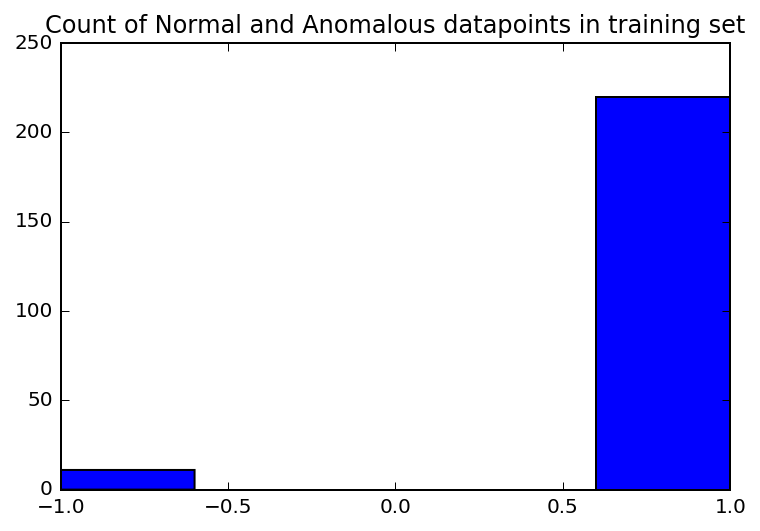

In [44]:
%config InlineBackend.figure_format = 'retina'
# let's take a look at the types of labels  are present in the data.
# The ones correspond to label 1 and 7's(outliers) correspond to label -1
#data.label.value_counts().plot(kind='bar')  
type(Xlabels)
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of Normal and Anomalous datapoints in training set")
plt.show()

##### MAKING OUR DATA ONE-CLASS

Later we're going to use scikit-learn's OneClassSVM predict function to generate output. This returns +1 or -1 to indicate whether the data is an "inlier" or "outlier" respectively. To make comparison easier later we'll replace our data's label with a matching +1 or -1 value. This also transforms our data from multi-class (multiple different labels) to one-class (boolean label), which is a prerequisite for using a one-class SVM




In [45]:

# series, not a new dataframe
target = Xlabels
# find the proportion of outliers we expect (aka where `labels == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/target.shape[0])

# Print the shape of the input data for sanity
print "Training data shape...",data.shape
 

('outliers.shape', (11,))
('outlier fraction', 0.047619047619047616)
Training data shape... (231, 256)


#### SPLITTING DATA INTO TRAINING AND TEST SETS



In [54]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape  


# We learn the digits on the first half of the digits
data_train, targets_train = train_data,train_target

# Now predict the value of the digit on the second half:
data_test, targets_test = test_data,test_target



### TRAINING THE MODELS: OneClass SVM, LINEAR KERNEL with Random Fourier Features, RBF kernel



In [55]:
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA
from sklearn import metrics 

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()
oneClass_svm = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])



# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

oneClass_svm_time = time()
oneClass_svm.fit(data_train, targets_train) 
preds = oneClass_svm.predict(data_train)  
targs = targets_train
oneClass_svm_score = metrics.accuracy_score(targs, preds)  
oneClass_svm_time = time() - oneClass_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
fourier_times = []


for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    fourier_scores.append(fourier_score)


('nu', 0.047619047619047616)


### Plotting the Accuracy 

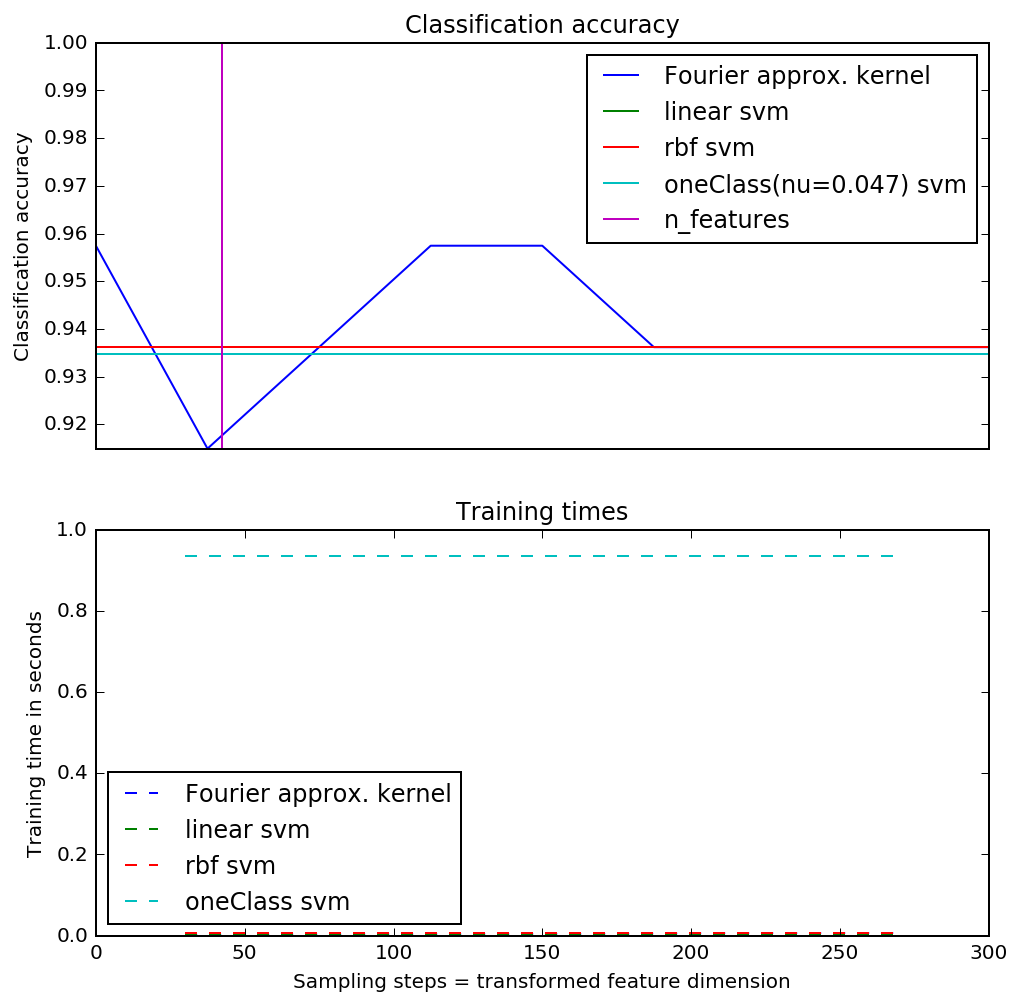

In [56]:
%config InlineBackend.figure_format = 'retina'
# plot the results:
plt.figure(figsize=(8, 8))
accuracy = plt.subplot(211)
# second y axis for timeings
timescale = plt.subplot(212)


accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [oneClass_svm_score, oneClass_svm_score], label="oneClass(nu=0.047) svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [oneClass_svm_score, oneClass_svm_score], '--', label='oneClass svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')

### Visualize the decision surface, projected down to the first two principal components of the dataset

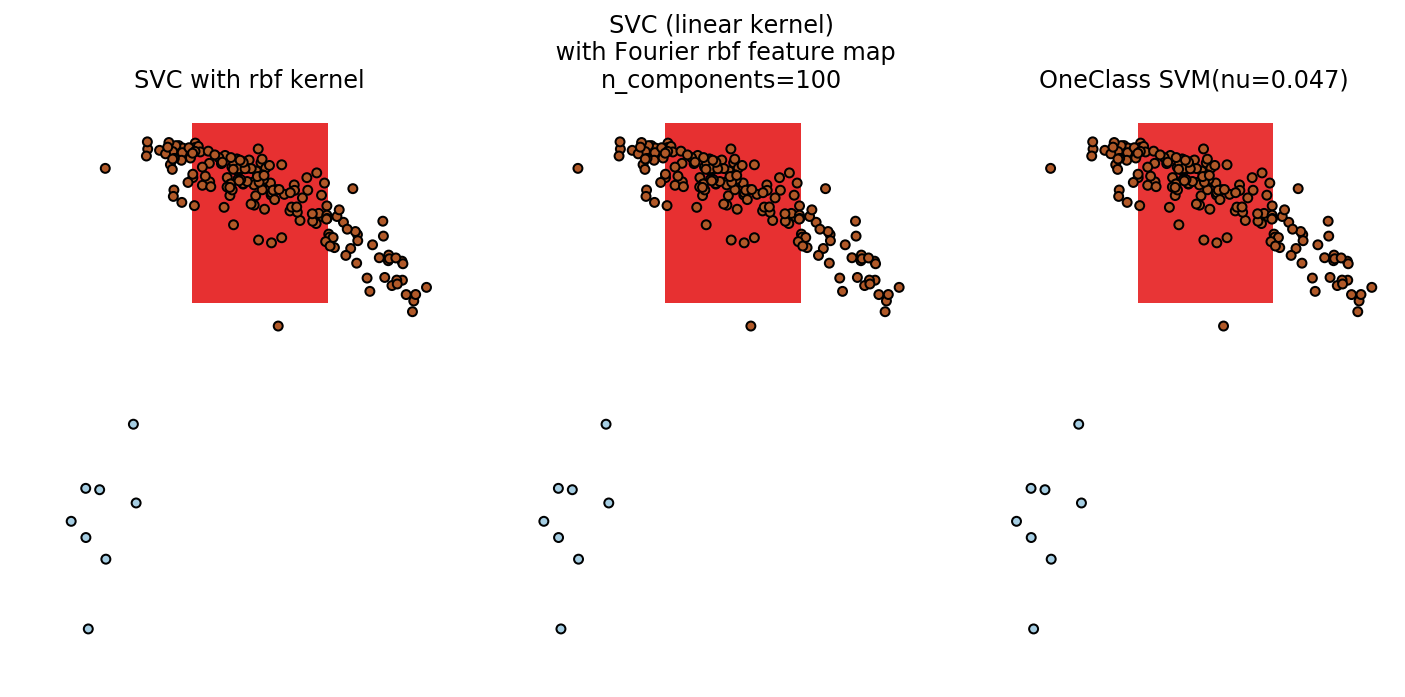

In [57]:
%config InlineBackend.figure_format = 'retina'
# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'OneClass SVM(nu=0.047)']

# plt.tight_layout()
plt.figure(figsize=(12, 5))

# predict and plot
for i, clf in enumerate((kernel_svm,fourier_approx_svm,oneClass_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=targets_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
# plt.tight_layout()
plt.show()
